# Import libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer, KNNImputer

# pipeline construction
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from boruta import BorutaPy

# model evaluation
import sklearn.metrics as metrics

# saving models
from joblib import dump

# remove annoying warnings and set settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 110)

# Load dataset

In [2]:
df = pd.read_csv('final_train.csv', index_col=0)
print(f'Train shape: {df.shape}')
df

Train shape: (11086, 572)


,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32",...,tGravityAcc-max()-Z,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAccMag-arCoeff()1,tGravityAccMag-arCoeff()2,tGravityAccMag-arCoeff()3,tGravityAccMag-arCoeff()4,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,6.137246,2.503062,5.776680,3.242765,-1.352936,-1.537732,2.828395,8.603183,-2.228620,5.355308,3.987723,1.880228,1.384042,-2.163548,0.483175,...,-1.499318,2.246320,2.861260,3.815614,-2.151051,-3.122438,-0.336110,6.357369,3.741996,1.394575,4.017211,2.481302,5.774536,1.754626,1.180533,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,5.740178,2.803435,5.484726,2.102368,-1.355854,-1.416568,2.527046,8.046001,-1.986672,5.284168,3.598328,1.892567,1.417711,-2.027475,0.436458,...,-0.703212,2.488702,2.391994,5.884982,-2.187197,-3.306482,-0.814718,6.077734,3.720622,1.202847,4.050714,4.539801,4.618405,1.727481,0.220730,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,6.158630,2.495276,5.776843,3.314383,-1.352860,-1.537483,2.845718,8.618923,-2.232214,5.378175,3.998898,1.879989,1.372814,-2.169002,0.485317,...,-2.863580,4.616200,1.336379,0.032001,-2.500477,-3.788376,0.559196,5.893237,3.621391,1.430272,4.146776,3.005560,5.407139,1.731942,0.066625,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.071755,2.024442,3.0
3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,3.355701,5.695567,2.592818,5.705653,1.968913,-1.353831,-1.490043,2.591209,8.453702,-2.161158,5.266233,3.829890,1.883672,1.424886,-2.101272,0.470061,...,-1.554225,2.254465,2.830937,3.575867,-2.153766,-3.131598,-0.272234,6.314269,3.698913,1.319806,4.098944,3.957257,5.202196,1.735761,-0.454503,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
4,LAYING,-1.548333,-0.139628,-2.380889,NaN,0.067613,-0.887342,6.007361,-11.970485,3.621984,6.158630,2.495276,5.776843,3.314383,-1.352860,-1.537483,2.845718,8.618923,-2.232214,5.378175,3.998898,1.879989,1.372814,-2.169002,0.485317,...,-2.863580,4.616200,1.336379,0.032001,-2.500477,NaN,0.559196,5.893237,3.621391,1.430272,4.146776,3.005560,5.407139,1.731942,0.066625,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.102513,2.024442,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11081,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,5.740178,2.803435,5.484726,2.102368,-1.355854,-1.416568,2.527046,8.046001

# Analyze dataset

Unique values for the target - we can assume that the set is **balanced**.

In [3]:
df['Activity'].value_counts(normalize=True)*100

LAYING                19.547177
SITTING               18.212159
STANDING              17.851344
WALKING               17.138734
WALKING_UPSTAIRS      14.730290
WALKING_DOWNSTAIRS    12.520296
Name: Activity, dtype: float64

In [4]:
pd.DataFrame(df.groupby(['Activity', 
             'void()'])['void()'].count()).groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

void()
Activity           void()           
LAYING             1.0     11.854951
                   2.0     14.039981
                   3.0     74.105067
SITTING            1.0     37.151394
                   2.0     25.298805
                   3.0     37.549801
STANDING           1.0     32.030457
                   2.0     33.857868
                   3.0     34.111675
WALKING            1.0     35.657686
                   2.0     34.495510
                   3.0     29.846804
WALKING_DOWNSTAIRS 1.0     32.802317
                   2.0     34.757422
                   3.0     32.440261
WALKING_UPSTAIRS   1.0     11.124845
                   2.0     72.187886
                   3.0     16.687268

###### Missing data

In columns

In [5]:
missing_columns = pd.DataFrame(df.isnull().sum() / df.shape[0] * 100.00).rename(columns={0:'Percentage_of_missing'})
missing_columns.loc[missing_columns['Percentage_of_missing']>0.75,:]

,Percentage_of_missing
"fBodyGyro-bandsEnergy()-33,48",0.757712


In rows

In [6]:
missing_rows = df.isnull().sum(axis=1)
missing_rows.loc[missing_rows>=1] = 1
print(missing_rows.sum() / missing_rows.shape[0])

0.1318780443802995


In [7]:
missing_rows = df.isnull().sum(axis=1)
missing_rows.loc[missing_rows>=40]

692     40
804     40
3036    40
3536    40
5397    40
6220    40
6796    40
8866    40
dtype: int64

In [8]:
df['subject'].isnull().sum()

0

There is not much missing data

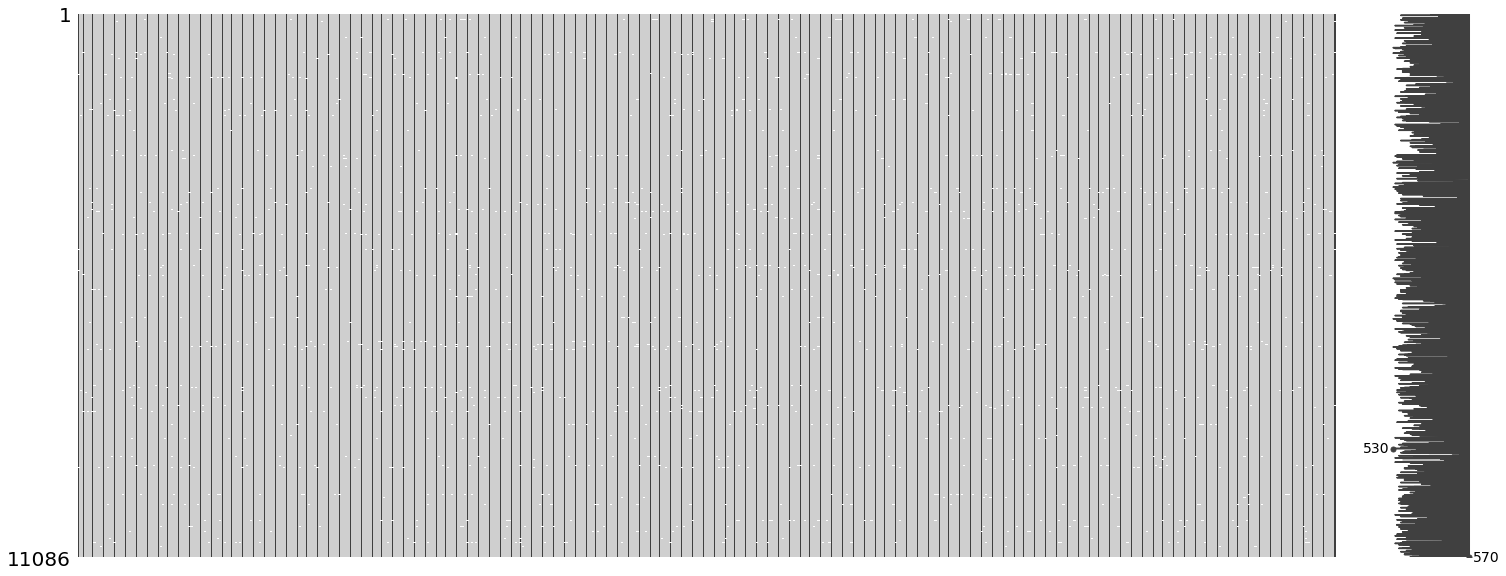

In [9]:
msno.matrix(df[df.columns[df.isna().any()]])
plt.show()

###### PCA data explanation

In [10]:
imputer = KNNImputer(n_neighbors=21)
df_imputer = imputer.fit_transform(df.drop('Activity', axis=1).copy())

power_transformer = PowerTransformer()
df_power_transformer = power_transformer.fit_transform(df_imputer)

scaler = StandardScaler()
df_scaler = scaler.fit_transform(df_power_transformer)

pca = PCA(random_state=42)
df_pca = pca.fit_transform(df_scaler)

tsne = TSNE(random_state=42)
df_tsne = tsne.fit_transform(df_pca)

df_pca = pd.DataFrame(np.concatenate([df_pca,
                          np.array(df['Activity']).reshape(-1, 1)],
                          axis=1))

df_tsne = pd.DataFrame(np.concatenate([df_tsne,
                          np.array(df['Activity']).reshape(-1, 1)],
                          axis=1))

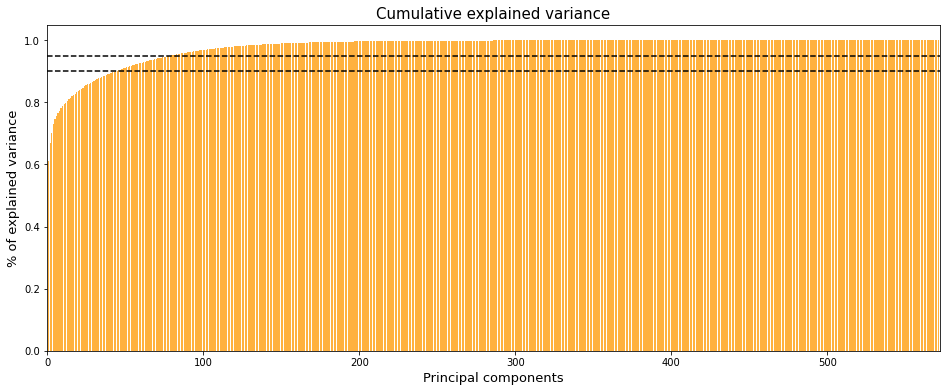

In [11]:
fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(wspace=.4, hspace=.4)

ax = fig.add_subplot(1, 1, 1)
ax.bar(range(1, 1+pca.n_components_),
       np.cumsum(pca.explained_variance_ratio_),
       color='#FFB13F')
ax.set_xlim(0, df_pca.shape[1])
plt.axhline(0.90, color='black', linestyle='--')
plt.axhline(0.95, color='black', linestyle='--') 
plt.title('Cumulative explained variance', fontsize=15)
plt.xlabel('Principal components', fontsize=13)
plt.ylabel('% of explained variance', fontsize=13)
plt.show()

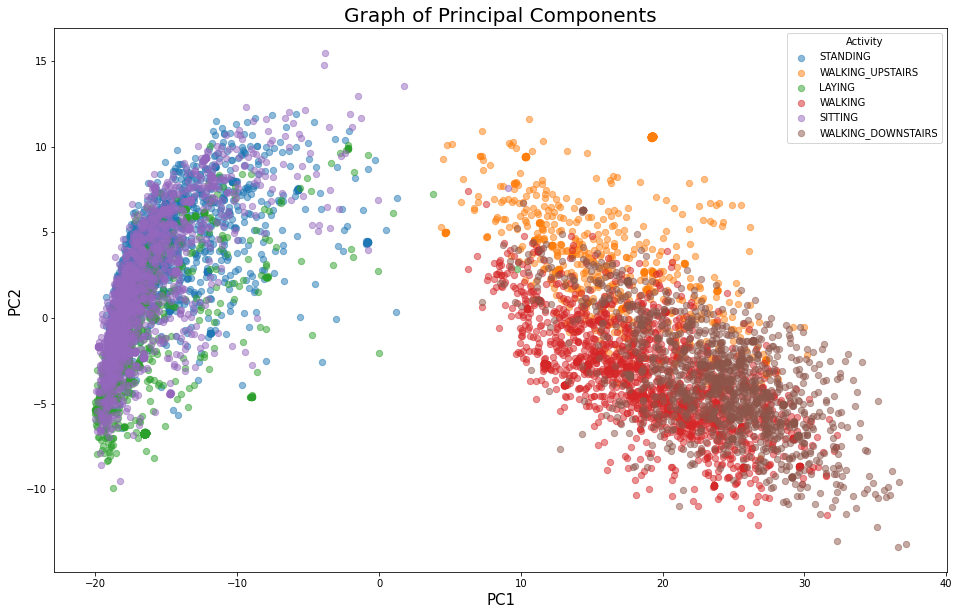

In [12]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

for label in df['Activity'].unique():
    img = ax.scatter(x=df_pca[df_pca.iloc[:, -1]==label][0],
                     y=df_pca[df_pca.iloc[:, -1]==label][1],
                     label=label, s=40, alpha=0.5)
ax.set_xlabel(xlabel='PC1', size=15)
ax.set_ylabel(ylabel='PC2', size=15)
ax.set_title('Graph of Principal Components', size=20)
plt.legend(title='Activity')
plt.savefig(f'graphics/02_pca.png', transparent=True, dpi=300)
plt.show()

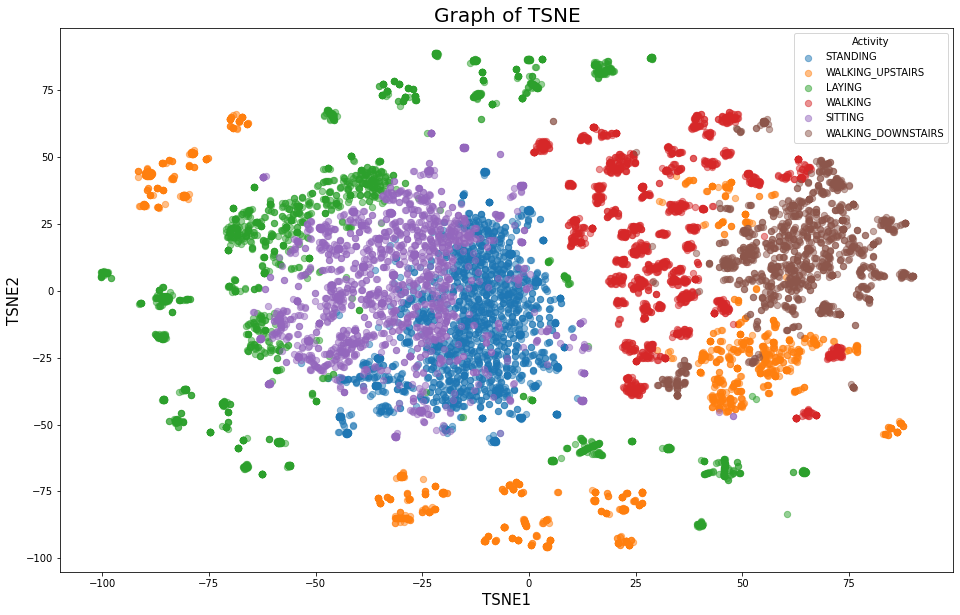

In [13]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

for label in df['Activity'].unique():
    img = ax.scatter(x=df_tsne[df_tsne.iloc[:, -1]==label][0],
                     y=df_tsne[df_tsne.iloc[:, -1]==label][1],
                     label=label, s=40, alpha=0.5)
ax.set_xlabel(xlabel='TSNE1', size=15)
ax.set_ylabel(ylabel='TSNE2', size=15)
ax.set_title('Graph of TSNE', size=20)
plt.legend(title='Activity')
plt.savefig(f'graphics/03_tsne.png', transparent=True, dpi=300)
plt.show()

# Split into training and test set

In [14]:
X = df.drop('Activity', axis=1).copy()
y = df['Activity'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Custom Transformers

In [15]:
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_select: list):
        self.columns_to_select = columns_to_select
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_copy = X.loc[:, X.columns.isin(self.columns_to_select)].copy()
        return X_copy

class ImputeMisingsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method = 'mean'):
        self.method = method
        self.impute_values = {}
    
    def fit(self, X, y = None):
        if self.method == 'mean':
            for col in X:
                mean = X[col].mean()
                self.impute_values[col] = mean
        elif self.method == 'median':
            for col in X:
                median = X[col].median()
                self.impute_values[col] = median
        return self
    
    def transform(self, X, y = None):
        X_features = X.copy()
        for col in X_features:
            value_to_impute = self.impute_values[col]
            X_features[col] = X_features[col].fillna(value_to_impute)
        return X_features

class BorutaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, boruta=True):
        self.boruta = boruta
    
    def fit(self, X, y):        
        
        if self.boruta == True:
            feature_selector = BorutaPy(RandomForestClassifier(max_depth=5, n_jobs=-1), n_estimators='auto')
            feature_selector.fit(np.array(X), np.array(y))
            self.selected_features = X.columns[feature_selector.support_].to_list()
            
        return self
    
    def transform(self, X, y = None):
        
        X_features = X.copy()

        if self.boruta == True:
            X_features = X_features[self.selected_features]
        
        return X_features

class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.boundaries = {}    
        
    def fit( self, X, y = None ):
        X = np.array(X)
        for col in X:
            iqr = np.nanpercentile(X[col], 75) - np.nanpercentile(X[col], 25)
            lower, upper = (np.nanpercentile(X[col], 25) - 1.5 * iqr), (np.nanpercentile(X[col], 75) + 1.5 * iqr)
            self.boundaries[col] = [lower, upper]
        return self    
    
    def transform( self, X, y = None ):
        X_copy = X.copy()
        
        for col in X_copy:
            # if values are smaller than lower, make them lower
            X_copy.loc[X_copy[col] < self.boundaries[col][0], col] = self.boundaries[col][0]            
            
            # if values are bigger than upper, make them upper
            X_copy.loc[X_copy[col] > self.boundaries[col][1], col] = self.boundaries[col][1]
        return X_copy

# Pipeline - Train models

In [16]:
columns_to_select = df.drop(['Activity', 'subject'], axis=1).columns

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

### Evaluate functions

In [17]:
metrics_dataframe = pd.DataFrame() 
models = {}

def calculate_metrics(model, name, model_pipeline, model_params):
    
    # Metrics dataframe
    global metrics_dataframe, models
    models[name] = {}
    models[name]['model'] = model
    models[name]['y_pred'] = model.predict(X_test)
    models[name]['accuracy_score'] = metrics.accuracy_score(y_test, models[name]['y_pred'])
    
    df = pd.DataFrame({'accuracy': models[name]['accuracy_score']}, index = [name])
    metrics_dataframe = metrics_dataframe.append(df)
    display(metrics_dataframe)
    
    # Classification Report
    print('\nClassification Report')
    print(metrics.classification_report(y_test, models[name]['y_pred']))
    
    # Confusion matrix
    print('\nConfusion matrix')
    fig, ax = plt.subplots(figsize=(12, 8))
    metrics.plot_confusion_matrix(models[name]['model'], X_test, y_test,
                                  cmap=plt.cm.Blues, normalize=None, ax=ax)
    ax.tick_params(axis='x', rotation=45)
    plt.savefig(f'graphics/04_model_{name}_confusion matrix.png', transparent=True, dpi=300)
    plt.show()
    
    # Train model for whole dataset
    model_whole_dataset = model_pipeline.set_params(**model_params)
    model_whole_dataset = model_whole_dataset.fit(X, y)
    
    # save model
    dump(models[name]['model'], f'models/{name}_on_train_dataset.pkl')
    dump(models[name]['model'], f'models/{name}_on_whole_dataset.pkl')
    print(f'The model {name} has been saved')

### Decision tree model

In [18]:
dtree_pipeline = Pipeline(steps=[('select_columns', SelectColumnsTransformer(columns_to_select = columns_to_select)),
                                 ('impute_missing_values', KNNImputer(n_neighbors=21)),
                                 ('classifier', DecisionTreeClassifier(max_depth=1))])

param_dtree = {
    'classifier__max_depth': [3, 7, 10, 12, 15]
}

dtree = GridSearchCV(dtree_pipeline, param_dtree, cv=kfold, scoring = 'accuracy', n_jobs=-1)
dtree.fit(X_train, y_train)

print("The best estimator: ", dtree.best_estimator_,
      "\nThe best score: ", dtree.best_score_,
      "\nThe best parameters: ", dtree.best_params_, sep="\n")
dtree_model = dtree.best_estimator_

The best estimator: 
Pipeline(steps=[('select_columns',
                 SelectColumnsTransformer(columns_to_select=Index(['angle(X,gravityMean)', 'angle(Y,gravityMean)', 'angle(Z,gravityMean)',
       'angle(tBodyAccJerkMean),gravityMean)', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyGyroJerkMean,gravityMean)',
       'angle(tBodyGyroMean,gravityMean)', 'energy-mean()',
       'fBodyAcc-bandsEnergy()-1,16', 'fBodyAc...
       'tGravityAccMag-energy()', 'tGravityAccMag-entropy()',
       'tGravityAccMag-iqr()', 'tGravityAccMag-mad()', 'tGravityAccMag-max()',
       'tGravityAccMag-mean()', 'tGravityAccMag-min()', 'tGravityAccMag-sma()',
       'tGravityAccMag-std()', 'void()'],
      dtype='object', length=570))),
                ('impute_missing_values', KNNImputer(n_neighbors=21)),
                ('classifier', DecisionTreeClassifier(max_depth=10))])

The best score: 
0.9468876860622463

The best parameters: 
{'classifier__max_depth': 10}


,accuracy
dtree,0.959423



Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       433
           SITTING       0.93      0.94      0.94       404
          STANDING       0.94      0.93      0.94       396
           WALKING       0.95      0.97      0.96       380
WALKING_DOWNSTAIRS       0.97      0.96      0.96       278
  WALKING_UPSTAIRS       0.96      0.95      0.96       327

          accuracy                           0.96      2218
         macro avg       0.96      0.96      0.96      2218
      weighted avg       0.96      0.96      0.96      2218


Confusion matrix


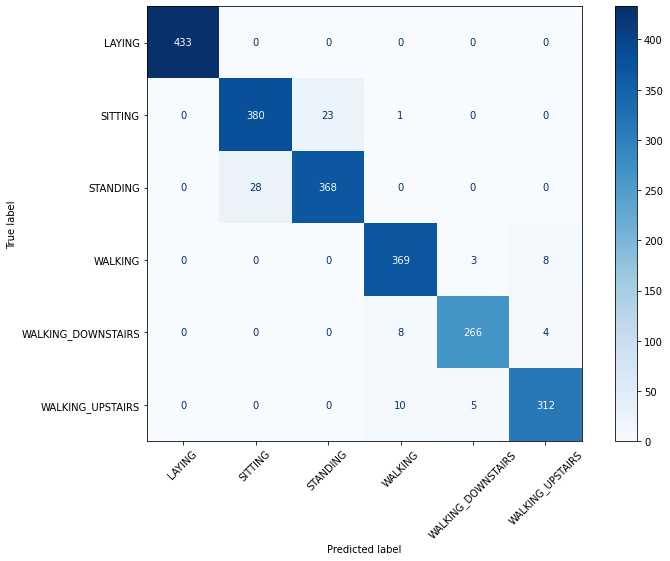

The model dtree has been saved


In [19]:
calculate_metrics(model = dtree_model, name = 'dtree',
                  model_pipeline = dtree_pipeline, model_params = dtree.best_params_)

### Decision tree model + Feature Selection

In [20]:
dtree_fs_pipeline = Pipeline(steps=[('select_columns', SelectColumnsTransformer(columns_to_select = columns_to_select)),
                                    ('impute_missing_values', KNNImputer(n_neighbors=21)),
                                    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators = 1000))),
                                    ('classifier', DecisionTreeClassifier(max_depth=1))])

param_dtree_fs = {
    'classifier__max_depth': [3, 7, 10, 12, 15]
}

dtree_fs = GridSearchCV(dtree_fs_pipeline, param_dtree_fs, cv=kfold, scoring = 'accuracy', n_jobs=-1)
dtree_fs.fit(X_train, y_train)

print("The best estimator: ", dtree_fs.best_estimator_,
      "\nThe best score: ", dtree_fs.best_score_,
      "\nThe best parameters: ", dtree_fs.best_params_, sep="\n")
dtree_fs_model = dtree_fs.best_estimator_

The best estimator: 
Pipeline(steps=[('select_columns',
                 SelectColumnsTransformer(columns_to_select=Index(['angle(X,gravityMean)', 'angle(Y,gravityMean)', 'angle(Z,gravityMean)',
       'angle(tBodyAccJerkMean),gravityMean)', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyGyroJerkMean,gravityMean)',
       'angle(tBodyGyroMean,gravityMean)', 'energy-mean()',
       'fBodyAcc-bandsEnergy()-1,16', 'fBodyAc...
       'tGravityAccMag-iqr()', 'tGravityAccMag-mad()', 'tGravityAccMag-max()',
       'tGravityAccMag-mean()', 'tGravityAccMag-min()', 'tGravityAccMag-sma()',
       'tGravityAccMag-std()', 'void()'],
      dtype='object', length=570))),
                ('impute_missing_values', KNNImputer(n_neighbors=21)),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000))),
                ('classifier', DecisionTreeClassifier(max_depth=12))])

The best score: 
0.949594046008119

The best parameters: 
{'cla

,accuracy
dtree,0.959423
dtree_plus_feature_selection,0.958521



Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       433
           SITTING       0.94      0.94      0.94       404
          STANDING       0.93      0.94      0.94       396
           WALKING       0.96      0.97      0.97       380
WALKING_DOWNSTAIRS       0.95      0.96      0.96       278
  WALKING_UPSTAIRS       0.96      0.94      0.95       327

          accuracy                           0.96      2218
         macro avg       0.96      0.96      0.96      2218
      weighted avg       0.96      0.96      0.96      2218


Confusion matrix


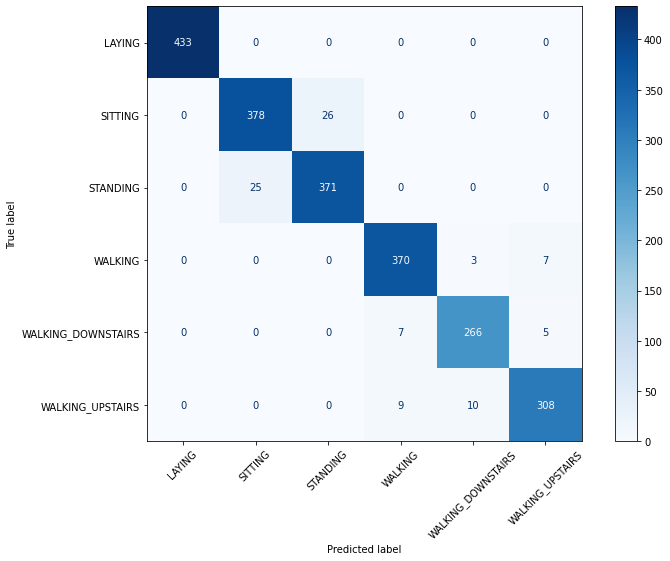

The model dtree_plus_feature_selection has been saved


In [21]:
calculate_metrics(model = dtree_fs_model, name = 'dtree_plus_feature_selection',
                  model_pipeline = dtree_fs_pipeline, model_params = dtree_fs.best_params_)

### Random Forest model

In [22]:
random_forest_pipeline = Pipeline(steps=[('select_columns', SelectColumnsTransformer(columns_to_select = columns_to_select)),
                                 ('impute_missing_values', KNNImputer(n_neighbors=21)),
                                 ('classifier', RandomForestClassifier(max_depth=10, n_estimators=1000))])

param_random_forest = {
    'classifier__max_depth': [4, 5, 7, 10],
    'classifier__n_estimators': [2000]
}

random_forest = GridSearchCV(random_forest_pipeline, param_random_forest, cv=kfold, scoring = 'accuracy', n_jobs=-1)
random_forest.fit(X_train, y_train)

print("The best estimator: ", random_forest.best_estimator_,
      "\nThe best score: ", random_forest.best_score_,
      "\nThe best parameters: ", random_forest.best_params_, sep="\n")
random_forest_model = random_forest.best_estimator_

The best estimator: 
Pipeline(steps=[('select_columns',
                 SelectColumnsTransformer(columns_to_select=Index(['angle(X,gravityMean)', 'angle(Y,gravityMean)', 'angle(Z,gravityMean)',
       'angle(tBodyAccJerkMean),gravityMean)', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyGyroJerkMean,gravityMean)',
       'angle(tBodyGyroMean,gravityMean)', 'energy-mean()',
       'fBodyAcc-bandsEnergy()-1,16', 'fBodyAc...
       'tGravityAccMag-energy()', 'tGravityAccMag-entropy()',
       'tGravityAccMag-iqr()', 'tGravityAccMag-mad()', 'tGravityAccMag-max()',
       'tGravityAccMag-mean()', 'tGravityAccMag-min()', 'tGravityAccMag-sma()',
       'tGravityAccMag-std()', 'void()'],
      dtype='object', length=570))),
                ('impute_missing_values', KNNImputer(n_neighbors=21)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=2000))])

The best score: 
0.9760938204781237

The best parameters: 
{'classifier__max_depth': 10, 'c

,accuracy
dtree,0.959423
dtree_plus_feature_selection,0.958521
random_forest,0.977457



Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       433
           SITTING       0.97      0.95      0.96       404
          STANDING       0.96      0.97      0.96       396
           WALKING       0.97      0.99      0.98       380
WALKING_DOWNSTAIRS       0.99      0.99      0.99       278
  WALKING_UPSTAIRS       0.98      0.96      0.97       327

          accuracy                           0.98      2218
         macro avg       0.98      0.98      0.98      2218
      weighted avg       0.98      0.98      0.98      2218


Confusion matrix


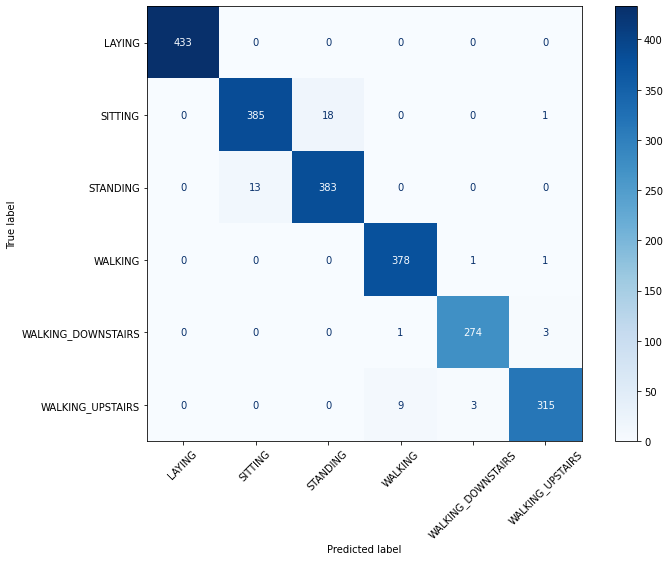

The model random_forest has been saved


In [23]:
calculate_metrics(model = random_forest_model, name = 'random_forest',
                  model_pipeline = random_forest_pipeline, model_params = random_forest.best_params_)

### Random Forest model + Feature Selection

In [24]:
random_forest_fs_pipeline = Pipeline(steps=[('select_columns', SelectColumnsTransformer(columns_to_select = columns_to_select)),
                                            ('impute_missing_values', KNNImputer(n_neighbors=21)),
                                            ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators = 1000))),
                                            ('classifier', RandomForestClassifier(max_depth=10, n_estimators=1000))])

param_random_forest_fs = {
    'classifier__max_depth': [5, 7, 10],
    'classifier__n_estimators': [2000]
}

random_forest_fs = GridSearchCV(random_forest_fs_pipeline, param_random_forest_fs, cv=kfold, scoring = 'accuracy', n_jobs=-1)
random_forest_fs.fit(X_train, y_train)

print("The best estimator: ", random_forest_fs.best_estimator_,
      "\nThe best score: ", random_forest_fs.best_score_,
      "\nThe best parameters: ", random_forest_fs.best_params_, sep="\n")
random_forest_fs_model = random_forest_fs.best_estimator_

The best estimator: 
Pipeline(steps=[('select_columns',
                 SelectColumnsTransformer(columns_to_select=Index(['angle(X,gravityMean)', 'angle(Y,gravityMean)', 'angle(Z,gravityMean)',
       'angle(tBodyAccJerkMean),gravityMean)', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyGyroJerkMean,gravityMean)',
       'angle(tBodyGyroMean,gravityMean)', 'energy-mean()',
       'fBodyAcc-bandsEnergy()-1,16', 'fBodyAc...
       'tGravityAccMag-iqr()', 'tGravityAccMag-mad()', 'tGravityAccMag-max()',
       'tGravityAccMag-mean()', 'tGravityAccMag-min()', 'tGravityAccMag-sma()',
       'tGravityAccMag-std()', 'void()'],
      dtype='object', length=570))),
                ('impute_missing_values', KNNImputer(n_neighbors=21)),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000))),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=2000))])

The best score: 
0.97417681

,accuracy
dtree,0.959423
dtree_plus_feature_selection,0.958521
random_forest,0.977457
random_forest_plus_feature_selection,0.973850



Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       433
           SITTING       0.96      0.95      0.95       404
          STANDING       0.95      0.96      0.95       396
           WALKING       0.98      0.99      0.98       380
WALKING_DOWNSTAIRS       0.98      0.99      0.98       278
  WALKING_UPSTAIRS       0.98      0.96      0.97       327

          accuracy                           0.97      2218
         macro avg       0.97      0.97      0.97      2218
      weighted avg       0.97      0.97      0.97      2218


Confusion matrix


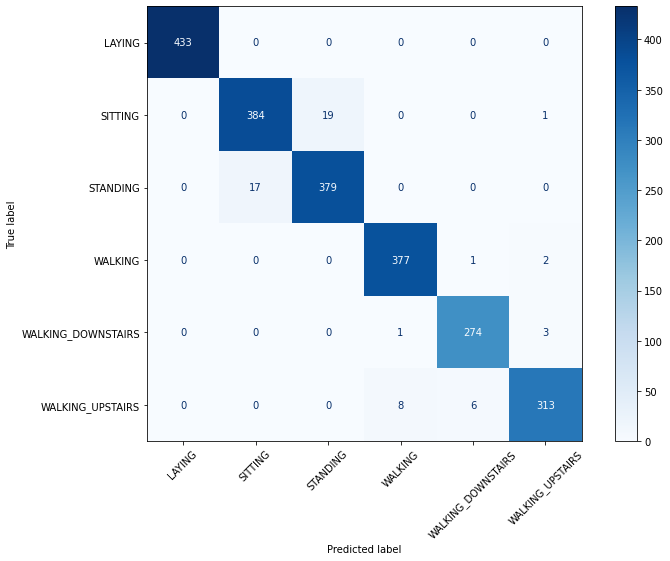

The model random_forest_plus_feature_selection has been saved


In [25]:
calculate_metrics(model = random_forest_fs_model, name = 'random_forest_plus_feature_selection',
                  model_pipeline = random_forest_fs_pipeline, model_params = random_forest_fs.best_params_)

# Explanation of the model

In [26]:
sel = random_forest_fs_model.named_steps['feature_selection']
selected_feat = X_train.drop(['subject'], axis=1).columns[(sel.get_support())]
len(selected_feat)

X_train[selected_feat]

,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-9,16",fBodyAcc-energy()-X,fBodyAcc-entropy()-X,fBodyAcc-mad()-X,fBodyAcc-max()-X,fBodyAcc-mean()-X,fBodyAcc-meanFreq()-X,fBodyAcc-meanFreq()-Y,fBodyAcc-meanFreq()-Z,fBodyAcc-skewness()-X,fBodyAcc-sma(),fBodyAcc-std()-X,"fBodyAccJerk-bandsEnergy()-1,16","fBodyAccJerk-bandsEnergy()-1,16.1","fBodyAccJerk-bandsEnergy()-1,24","fBodyAccJerk-bandsEnergy()-1,24.1","fBodyAccJerk-bandsEnergy()-1,8","fBodyAccJerk-bandsEnergy()-1,8.1",...,"tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y",tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-std()-X,tGravityAccMag-arCoeff()1,tGravityAccMag-max(),tGravityAccMag-std()
5419,-1.567956,-0.903416,-2.484880,3.533184,5.755107,-1.517259,1.372815,1.851947,6.033875,-1.497116,2.440470,5.269215,-7.562134,-3.105771,5.354039,-1.888552,-1.478551,-0.946715,0.401807,-0.221453,6.387482,-2.333536,2.391867,5.566300,2.643083,...,-1.630970,3.125042,-2.735304,7.598147,0.298408,-4.006097,1.597618,-3.519175,1.721656,6.813717,3.246233,-5.950167,0.641397,-0.980963,2.555227,3.083800,5.670659,-2.230003,-2.962096,-0.906562,5.934137,2.266555,5.746460,2.641317,-0.086747
7282,-1.544257,0.526195,-2.437286,3.614666,5.775032,-1.535915,1.374643,1.852824,6.096424,-1.055349,2.505030,5.249007,-7.595525,-3.367379,2.756406,-1.958986,-1.027518,-0.811951,0.685241,-0.222160,6.386586,-2.333806,2.390417,5.565883,2.644594,...,2.565952,2.949892,-1.979497,5.662573,1.484464,-4.288128,1.860012,-5.459263,1.800678,8.394366,3.026712,-3.399526,-0.297807,-1.827595,5.169717,0.451039,2.823598,-2.579712,-4.174298,-0.098012,6.290158,3.507014,3.688422,3.174920,1.921638
9199,-1.572492,-0.882749,-2.455993,2.442010,5.483416,-1.296694,1.405122,1.604080,5.166818,-3.291836,2.027919,5.331924,-7.330461,-3.610630,4.792047,-1.918825,-0.984766,-1.364601,-0.599595,-0.465979,6.074750,-2.409913,2.285340,5.058644,2.329616,...,-0.949877,3.018482,-2.328572,6.690007,0.772927,-4.066322,1.544241,-3.493479,1.852970,7.906599,3.246233,-5.969550,0.663657,-1.411307,2.303520,3.044066,3.950174,-2.163041,-3.032661,-0.366090,6.304860,3.644915,5.586296,1.821078,-0.428362
811,-1.574322,-0.777359,-2.449418,3.246594,5.680937,-1.465137,1.426768,1.739995,5.796435,-3.019623,2.247478,5.289201,-7.450188,-3.877598,4.471856,-1.911792,-0.776267,-1.232539,0.010997,-0.336617,5.664271,-2.375579,2.157425,5.364071,2.339832,...,0.193294,2.992996,-2.181071,6.216665,1.123005,-4.097614,1.531047,-3.404476,1.846058,8.394366,3.246233,-6.009479,0.587396,-1.571692,2.246164,2.792288,3.541833,-2.152621,-3.149252,-0.276029,6.324663,3.706847,4.683787,2.285111,0.553132
10863,-1.573560,-0.804576,-2.447730,3.623698,5.777296,-1.537872,1.373150,1.853824,6.103741,-0.277287,2.538955,5.242110,-7.613012,-3.790691,3.982476,-1.902586,-0.451917,-0.806797,0.788853,-0.221349,6.388462,-2.333449,2.392353,5.566917,2.644697,...,-1.211730,3.062179,-2.458552,6.875211,0.750177,-4.483466,1.533782,-3.422443,1.841660,8.394366,3.246233,-5.996337,0.607528,-1.634517,2.257951,2.858812,3.436434,-2.153180,-3.092812,-0.277338,6.260836,3.722857,4.343317,3.194402,1.856519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5884,-1.569634,-0.747830,-2.484412,3.624037,5.777379,-1.537935,1.372419,1.853942,6.104013,-0.039049,2.543744,5.241302,-7.615740,-3.947037,3.623840,-1.915881,-0.142207

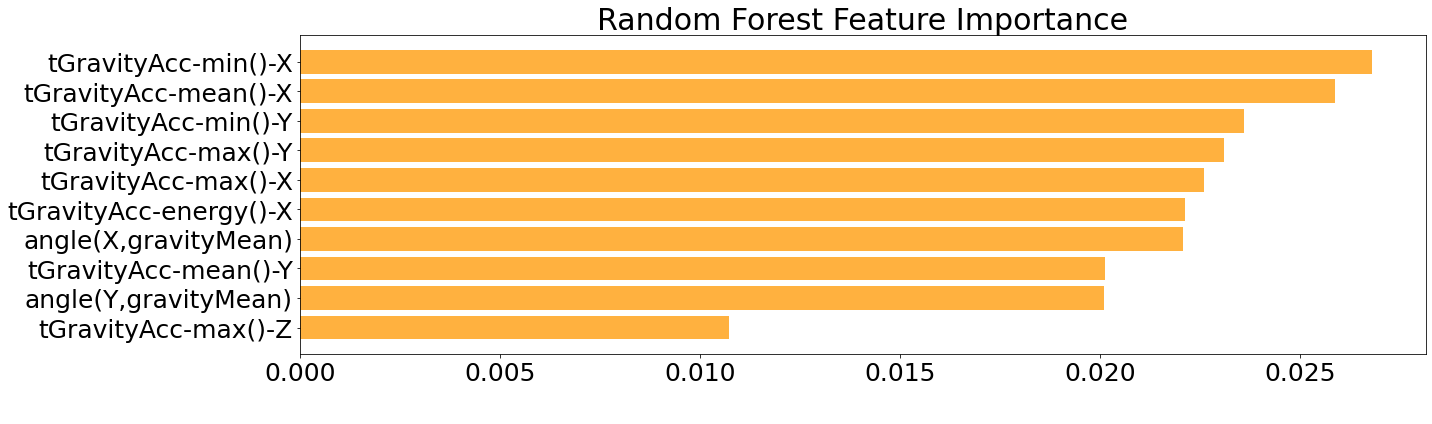

In [27]:
importance = sel.estimator_.feature_importances_
df_feature_importance=importance.argsort()
df_feature_importance=pd.DataFrame({
    'column':X.drop(['subject'], axis=1).columns[df_feature_importance],
    'importance':importance[df_feature_importance]
})
columns_feature_importance = df_feature_importance.sort_values(by='importance', ascending=False)['column'].tolist()
columns_feature_importance_more_0_01 = df_feature_importance[df_feature_importance['importance']>=0.01]['column'].tolist()
df_feature_importance = df_feature_importance[df_feature_importance['importance']>=0.01].copy().reset_index(drop=True)
df_feature_importance

plt.figure(figsize=(20, 6))
plt.barh(df_feature_importance['column'][-10:], df_feature_importance['importance'][-10:], color='#FFB13F')
plt.tick_params(axis='both', labelsize=25)
plt.title('Random Forest Feature Importance', size=30)
plt.xlabel(' ', size=27.5)
plt.tight_layout()
plt.savefig("graphics/05_random_forest_feature_importance.png", transparent=True, dpi=300)
plt.show()